In [598]:
from __future__ import division, print_function, unicode_literals
# This will likely require minor changes to work on Python2
import os
import re
import gzip
import time
import json
import subprocess
import logging
import operator
from importlib import reload
import itertools
from itertools import islice
from collections import Counter
from datetime import timedelta, date
import ftfy
import cytoolz as toolz
from cytoolz import count, take, concat, concatv, dissoc, sliding_window, unique, assoc, assoc_in
import pandas as pd
import numpy as np
import spacy
from scipy import spatial, stats
from sklearn import linear_model, decomposition, feature_extraction, metrics
import liwc
from vega import Vega, VegaLite
import altair as alt
from altair import Chart, X, Y, Axis, Color, Scale, SortField, Legend, Column
from IPython.display import display, SVG, HTML, Image
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('newsprint.mplstyle')

In [2]:
pd.options.display.max_colwidth = 300 # defaults to 50
pd.options.display.max_rows = 30 # defaults to 60

In [3]:
logging.basicConfig(level=logging.DEBUG)

In [4]:
# local modules
from presidents import logger, parse_date, tzinfos, calculate_election_day, jaccard_index, root
from presidents.readers import read_strings, read_ldjson
logger.setLevel(logging.INFO)

In [5]:
# import presidents.models; reload(presidents.models)
from presidents.models import standard_stopwords, nlp, parse, is_word

In [6]:
# import presidents.scraping.tapp; reload(presidents.scraping.tapp)
from presidents.scraping import tapp

In [7]:
# import presidents.text; reload(presidents.text)
from presidents.text import tokenize, token_counts, token_freqs, context_spans, context_tokens, iter_substantive_words

In [8]:
exports_dirpath = os.path.join(root, 'notebooks', 'Inaugural-Shift')

In [9]:
def export_altair_chart(chart, basename, dirpath=exports_dirpath):
    '''
    Render the given altair.Chart to a PDF at {dirpath}/{basename}.pdf, 
    and write the raw Vega-Lite JSON to {dirpath}/{basepath}.vl.json
    
    May need to install dependencies:
        brew install svg2pdf
        npm config set python python2.7
        npm install -g vega@2.6.5 vega-lite@1.3.1
    '''
    if not isinstance(chart, Chart):
        raise RuntimeError('chart must be an altair.Chart instance')
    if basename.endswith('.pdf'):
        raise RuntimeError('basename should not end in .pdf')
        
    vl_json_filepath = os.path.join(dirpath, '{}.vl.json'.format(basename))
    pdf_filepath = os.path.join(dirpath, '{}.pdf'.format(basename))
    
    vl_json_string = chart.to_json()
    try:
        with open(vl_json_filepath, 'x') as vl_json_file:
            vl_json_file.write(vl_json_string)
        logger.info('Wrote Vega-Lite to %s', vl_json_filepath)
    except FileExistsError as ex:
        logger.warning('Not writing Vega-Lite: %s', ex)
    
    try:
        vl2svg_proc = subprocess.run(['vl2svg'], stdout=subprocess.PIPE, input=vl_json_string, 
                                     universal_newlines=True, check=True)
        svg_string = vl2svg_proc.stdout
        with open(pdf_filepath, 'xb') as pdf_file:
            svg2pdf_proc = subprocess.run(['svg2pdf'], stdout=pdf_file, input=svg_string, 
                                          encoding='utf-8', check=True)
        logger.info('Wrote PDF to "%s"', pdf_filepath)
    except FileExistsError as ex:
        logger.warning('Not writing PDF: %s', ex)

In [548]:
def export_PIL_image(image, basename, format, dirpath=exports_dirpath):
    filepath = os.path.join(dirpath, '{}.{}'.format(basename, format))
    try:
        with open(filepath, 'xb') as file:
            image.save(file, format, Quality=100)
        logger.info('Wrote Image to "%s"', filepath)
    except FileExistsError as ex:
        logger.warning('Not writing Image: %s', ex)

## Data loading

In [10]:
nlp.meta

{'author': 'Explosion AI',
 'description': 'General-purpose English model, with tagging, parsing, entities and word vectors',
 'email': 'contact@explosion.ai',
 'lang': 'en',
 'license': 'CC BY-SA 3.0',
 'name': 'core_web_md',
 'spacy_version': '>=1.7.0,<2.0.0',
 'url': 'https://explosion.ai',
 'version': '1.2.1'}

In [11]:
presidents_lookup = dict(tapp.presidents)

In [12]:
liwc_parse_token, liwc_category_names = liwc.load_token_parser('/usr/local/data/liwc_2007.dic')

In [13]:
def liwc_scores(token_counts):
    '''
    Calculate the length-normalized LIWC category scores for the document described by the bag-of-words
    `token_counts`, which should be a mapping from lowercase strings to integer occurrences of those strings.
    
    Returns 0 for categories with no matches.
    '''
    length = sum(token_counts.values())
    counter = Counter()
    for token, count in token_counts.items():
        for category in liwc_parse_token(token):
            counter[category] += count
    return {category: (counter[category] / length) for category in liwc_category_names}

In [14]:
def cdi(token_counts):
    scores = liwc_scores(token_counts)
    categorical = sum(scores[k] for k in ('article', 'preps'))
    dynamic = sum(scores[k] for k in ('auxverb', 'ipron', 'ppron', 'adverb', 'conj', 'negate'))
    return categorical - dynamic

In [15]:
def is_speech(paper):
    title_is_blacklisted = paper['title'].startswith((
        'Press Release',
        'Memorandum',
        'Statement by the Press Secretary',
        'Notice',
        'Proclamation',
        'Statement of Administration Policy',
        'Executive Order',
        'Fact Sheet',
        'Press Gaggle', # not so sure about this one, perhaps too broad
    ))
    # exclude really short papers (like some that are just an embedded YouTube video)
    text_is_empty = len(paper['text']) < 140
    return not title_is_blacklisted and not text_is_empty

## Important Dates and Binning 

In [16]:
def merge_docs(docs, description=None):
    texts, timestamps = zip(*((doc.text, doc.user_data['timestamp']) for doc in docs))
    merged_doc = nlp(' '.join(texts), tag=False, parse=False, entity=False)
    merged_doc.user_data = dict(min_timestamp=min(timestamps), max_timestamp=max(timestamps))
    if description is not None:
        merged_doc.user_data['description'] = description
    return merged_doc

In [17]:
def bin_papers(papers):
    '''
    Group a single president's papers into 4 bins.
    Yields (bin_description, start_date, end_date, n_documents, joined_text) tuples,
    1 for each bin, so 4 total.
    '''
    # we use the paper timestamp / date multiple times, so we compute it once for each paper, first.
    papers = [dict(paper, date=parse_date(paper['timestamp']).date()) for paper in papers]
    # this raises an exception if there is no inaugural address in the list of papers
    inauguration_date = sorted(paper['date'] for paper in papers if 'Inaugural Address' in paper['title'])[0]
    election_date = calculate_election_day(inauguration_date)
    bins = [
        ('100 days before Election', 
         election_date - timedelta(days=100), 
         election_date),
        ('Election to Inaugural', 
         election_date, 
         inauguration_date),
        ('First 100 days in Office', 
         inauguration_date, 
         inauguration_date + timedelta(days=100)),
        ('Second 100 days in Office', 
         inauguration_date + timedelta(days=100), 
         inauguration_date + timedelta(days=200)),
    ]
    for description, start_date, end_date in bins:
        bin_papers = [paper for paper in papers if start_date < paper['date'] <= end_date]
        bin_text = ' '.join(paper['text'] for paper in bin_papers)
        yield description, start_date, end_date, len(bin_papers), bin_text

In [18]:
def _read_inaugural_docs():
    # 1101 is the category ID for 'Oral: Address - Inaugural'
    # 1110 is the category ID for 'Oral: Address  - "Inaugural" (Accidental Presidents)'
    for paper in tapp.read_category_papers(1101, 1110):
        doc = nlp(paper['text'])
        doc.user_data = dissoc(paper, 'text')
        yield doc

_cached_inaugural_docs = []
def load_inaugural_docs():
    '''
    Load (from cache, if possible) all inaugural docs
    '''
    if not _cached_inaugural_docs:
        logger.info('Loading inaugural docs from disk')
        _cached_inaugural_docs.extend(_read_inaugural_docs())
    return _cached_inaugural_docs

In [510]:
def _open_auto(filepath):
    if filepath.endswith('.gz'):
        return gzip.open(filepath)
    return open(filepath)

twitter_dirpath = os.path.join(root, 'data', 'twitter')

def _read_twitter_docs(screen_name):
    filepaths = [os.path.join(twitter_dirpath, filename) for filename in os.listdir(twitter_dirpath) 
                 if filename.startswith(screen_name + '-')]
    for filepath in filepaths:
        with _open_auto(filepath) as tweets_file:
            for line in tweets_file:
                tweet_dict = json.loads(line)
                raw_text = tweet_dict.get('full_text', tweet_dict.get('text'))
                text = ftfy.fix_text(raw_text)
                time_tuple = time.strptime(tweet_dict['created_at'], '%a %b %d %H:%M:%S %z %Y')
                timestamp_iso = time.strftime('%Y-%m-%dT%H:%M:%SZ', time_tuple)
                doc = nlp(text)
                doc.user_data = dict(id_str=tweet_dict['id_str'],
                                     source=tweet_dict['source'],
                                     timestamp=timestamp_iso)
                yield doc

_cached_twitter_docs = {}
def load_twitter_docs(screen_name):
    '''
    Load (from cache, if possible) all tweets for `screen_name`
    '''
    if screen_name not in _cached_twitter_docs:
        logger.info('Loading twitter docs from disk for screen_name "%s"', screen_name)
        _cached_twitter_docs[screen_name] = sorted(_read_twitter_docs(screen_name), 
                                                   key=lambda doc: doc.user_data['timestamp'])
    return _cached_twitter_docs[screen_name]

In [19]:
def _read_president_papers(president):
    papers = [paper for paper in tapp.read_president_papers(president) if is_speech(paper)]
    logger.info('Read {} papers from disk for president {}'.format(len(papers), president))
    return papers

_cached_president_papers = {}
def load_president_papers(president):
    if president not in _cached_president_papers:
        _cached_president_papers[president] = _read_president_papers(president)
    return _cached_president_papers[president]

In [20]:
def _read_president_docs(president):
    '''
    TODO: sometimes all we need is tokenization; add a function to cache 
    nlp(tag=False, parse=False, entity=False) calls?
    '''
    for paper in load_president_papers(president):
        doc = nlp(paper['text'])
        doc.user_data = dissoc(paper, 'text')
        yield doc
        
_cached_president_docs = {}
def load_president_docs(president):
    '''
    Load (from cache, if possible) all docs for the given president.
    '''
    if president not in _cached_president_docs:
        logger.info('Loading docs from disk for president "%s"', president)
        _cached_president_docs[president] = list(_read_president_docs(president))
    return _cached_president_docs[president]

In [21]:
def _read_president_doc(president):
    '''
    For `president` (an index; 35 = Kennedy; 44 = Obama),
    return a spaCy Doc instance
    with user_data: president, n_documents
    '''
    papers = load_president_papers(president)
    bins = list(bin_papers(papers))
    # combine bins into a single document
    text = ' '.join(bin_text for _, _, _, _, bin_text in bins)
    n_documents = sum(bin_n_documents for _, _, _, bin_n_documents, _ in bins)
    start_date = min(bin_start_date for _, bin_start_date, _, _, _ in bins)
    end_date = max(bin_end_date for _, _, bin_end_date, _, _ in bins) 
    doc = nlp(text)
    doc.user_data = dict(start_date=start_date, 
                         end_date=end_date, 
                         n_documents=n_documents)
    return doc

_cached_president_doc = {}
def load_president_doc(president):
    if president not in _cached_president_doc:
        logger.info('Loading doc from disk for president "%s"', president)
        _cached_president_doc[president] = _read_president_doc(president)
    return _cached_president_doc[president]

In [22]:
def _read_president_bindocs(president):
    '''
    For `president` (an index; 35 = Kennedy; 44 = Obama),
    return a tuple (id, name, docs)
    where docs is a list of spaCy Doc instances
    with user_data: bin, start_date, end_date, n_documents
    '''
    papers = load_president_papers(president)
    logger.info('Reading bindocs from {} papers for president {}'.format(len(papers), president))
    def iter_bindocs():
        for description, start_date, end_date, n_documents, text in bin_papers(papers):
            doc = nlp(text)
            doc.user_data = dict(description=description, 
                                 start_date=start_date, 
                                 end_date=end_date, 
                                 n_documents=n_documents)
            yield doc
    return list(iter_bindocs())

_cached_president_bindocs = {}
def load_president_bindocs(president):
    if president not in _cached_president_bindocs:
        logger.info('Loading bindocs from disk for president "%s"', president)
        _cached_president_bindocs[president] = _read_president_bindocs(president)
    return _cached_president_bindocs[president]

In [23]:
def sim_description(*docs):
    '''
    docs should be a list of bindocs 
    (spacy.doc.Doc instances with a description field in user_data)
    '''
    return ' ↔ '.join(doc.user_data['description'] for doc in docs)

In [24]:
def create_featurized_docs_df(docs, feature_functions, pivot=True):
    index_keys = list(unique(user_data_key for doc in docs for user_data_key in doc.user_data))
    def iter_rows():
        for doc in docs:
            index_values = [doc.user_data.get(index_key, '') for index_key in index_keys]
            for feature_function in feature_functions:
                yield index_values + [feature_function.__name__, feature_function(doc)]
    df = pd.DataFrame(iter_rows(), columns=index_keys + ['feature_name', 'feature_value'])
    if pivot:
        return df.pivot_table(values='feature_value', index=index_keys, columns='feature_name', aggfunc='first')
    return df    

In [25]:
def create_featurized_df(president_ids, feature_functions, pivot=True):
    index_columns = ['president_id', 'president']
    def iter_rows():
        for president_id in president_ids:
            name = presidents_lookup[president_id]
            doc = load_president_doc(president_id)
            for feature_function in feature_functions:
                yield president_id, name, feature_function.__name__, feature_function(doc)
    df = pd.DataFrame(iter_rows(), columns=index_columns + ['feature_name', 'feature_value'])
    if pivot:
        # this is similar (since all index+feature-name/value pairs are unique) to the pivot_table with aggfunc='first', 
        # but ends up with hierarchical columns.
        # specifying ...pivot(columns='feature_name', values='feature_value') is illegal, apparently
        #return df.set_index(index_columns).pivot(columns='feature_name')
        return df.pivot_table(values='feature_value', index=index_columns, columns='feature_name', aggfunc='first')
    return df

In [26]:
def create_featurized_bin_df(president_ids, feature_functions, pivot=True):
    index_columns = ['president_id', 'president', 'bin']
    def iter_rows():
        for president_id in president_ids:
            name = presidents_lookup[president_id]
            for bindoc in load_president_bindocs(president_id):
                bin_description = bindoc.user_data['description']
                for feature_function in feature_functions:
                    yield president_id, name, bin_description, feature_function.__name__, feature_function(bindoc)
    df = pd.DataFrame(iter_rows(), columns=index_columns + ['feature_name', 'feature_value'])
    if pivot:
        return df.pivot_table(values='feature_value', index=index_columns, columns='feature_name', aggfunc='first')
    return df

In [27]:
# token/type features
def n_documents(doc):
    return doc.user_data.get('n_documents', 1)

def n_tokens(doc):
    return len(doc)

def n_types(doc):
    return len(doc.count_by(spacy.attrs.LOWER))

token_type_feature_functions = [n_documents, n_tokens, n_types]

In [28]:
# bin metadata features
def start_date(doc):
    return doc.user_data['start_date']

def end_date(doc):
    return doc.user_data['end_date']

doc_date_feature_functions = [start_date, end_date]

In [29]:
class TokenMatcher(object):
    def __init__(self, tokens, name=None, max_tokens_in_name=5):
        self.string_ids = [nlp.vocab.strings[token] for token in tokens]
        if name is None:
            # since tokens may not be re-iterable, and we've already read from it once,
            # map back from the stored string_ids to tokens
            first_tokens = [nlp.vocab.strings[string_id] for string_id in take(max_tokens_in_name, self.string_ids)]
            if len(self.string_ids) > max_tokens_in_name:
                # swap out the last token with a marker indicating elision
                first_tokens[-1] = '…etc'
            name = '/'.join(first_tokens)
        self.__name__ = name
        
    def __call__(self, doc):
        '''
        doc must be a spaCy Doc instance.
        '''
        lower_counts = doc.count_by(spacy.attrs.LOWER)
        total = sum(lower_counts.values())
        return sum(lower_counts.get(string_id, 0) for string_id in self.string_ids) / total

## Descriptive statistics for bins

In [30]:
%%time
df_bin_stats = create_featurized_bin_df([41, 42, 43, 44, 45], doc_date_feature_functions + token_type_feature_functions)
df_bin_stats['types/tokens'] = df_bin_stats.n_types / df_bin_stats.n_tokens
display(df_bin_stats)

INFO:presidents:Loading bindocs from disk for president 41
INFO:presidents:Read 5014 papers from disk for president 41
INFO:presidents:Reading bindocs from 5014 papers for president 41
INFO:presidents:Loading bindocs from disk for president 42
INFO:presidents:Read 12503 papers from disk for president 42
INFO:presidents:Reading bindocs from 12503 papers for president 42
INFO:presidents:Loading bindocs from disk for president 43
INFO:presidents:Read 9186 papers from disk for president 43
INFO:presidents:Reading bindocs from 9186 papers for president 43
INFO:presidents:Loading bindocs from disk for president 44
INFO:presidents:Read 7856 papers from disk for president 44
INFO:presidents:Reading bindocs from 7856 papers for president 44
INFO:presidents:Loading bindocs from disk for president 45
INFO:presidents:Read 736 papers from disk for president 45
INFO:presidents:Reading bindocs from 736 papers for president 45


feature_name                                                 end_date  \
president_id president          bin                                     
41           George Bush        100 days before Election   1988-11-08   
                                Election to Inaugural      1989-01-20   
                                First 100 days in Office   1989-04-30   
                                Second 100 days in Office  1989-08-08   
42           William J. Clinton 100 days before Election   1992-11-03   
                                Election to Inaugural      1993-01-20   
                                First 100 days in Office   1993-04-30   
                                Second 100 days in Office  1993-08-08   
43           George W. Bush     100 days before Election   2000-11-07   
                                Election to Inaugural      2001-01-20   
                                First 100 days in Office   2001-04-30   
                                Second 100 days in Office  2001-08-08   
44           Barack Obama       100 days before Election   2008-11-04   
                                Election to Inaugural      2009-01-20   
                                First 100 days in Office   2009-04-30   
                                Second 100 days in Office  2009-08-08   
45           Donald J. Trump    100 days before Election   2016-11-08   
                                Election to Inaugural      2017-01-20   
                                First 100 days in Office   2017-04-30   
                                Second 100 days in Office  2017-08-08   

feature_name                                              n_documents  \
president_id president          bin                                     
41           George Bush        100 days before Election            3   
                                Election to Inaugural              12   
                                First 100 days in Office          368   
                                Second 100 days in Office         429   
42           William J. Clinton 100 days before Election            1   
                                Election to Inaugural               6   
                                First 100 days in Office          423   
                                Second 100 days in Office         485   
43           George W. Bush     100 days before Election            1   
                                Election to Inaugural              31   
                                First 100 days in Office          371   
                                Second 100 days in Office         366   
44           Barack Obama       100 days before Election          144   
                                Election to Inaugural              80   
                                First 100 days in Office          303   
                                Second 100 days in Office         335   
45           Donald J. Trump    100 days before Election           64   
                                Election to Inaugural              25   
                                First 100 days in Office          232   
                                Second 100 days in Office         267   

feature_name                                              n_tokens n_types  \
president_id president          bin                                          
41           George Bush        100 days before Election     11805    1944   
                                Election to Inaugural        57389    4291   
                                First 100 days in Office    362987   13218   
                                Second 100 days in Office   362302   14391   
42           William J. Clinton 100 days before Election       958     408   
                                Election to Inaugural         9524    1674   
                                First 100 days in Office   1076509   16258   
                                Second 100 days in Office  1186575   18001   
43    

CPU times: user 9min 2s, sys: 9.87 s, total: 9min 12s
Wall time: 9min 19s


In [31]:
%%time
df_stats = create_featurized_df([41, 42, 43, 44, 45], doc_date_feature_functions + token_type_feature_functions)
df_stats['types/tokens'] = df_stats.n_types / df_stats.n_tokens
display(df_stats)

INFO:presidents:Loading doc from disk for president 41
INFO:presidents:Loading doc from disk for president 42
INFO:presidents:Loading doc from disk for president 43
INFO:presidents:Loading doc from disk for president 44
INFO:presidents:Loading doc from disk for president 45


,feature_name,end_date,n_documents,n_tokens,n_types,start_date,types/tokens
president_id,president,,,,,,
41,George Bush,1989-08-08,812,794483,19446,1988-07-31,0.0244763
42,William J. Clinton,1993-08-08,915,2273566,23036,1992-07-26,0.0101321
43,George W. Bush,2001-08-08,769,1033892,19800,2000-07-30,0.0191509
44,Barack Obama,2009-08-08,862,1678236,22849,2008-07-27,0.0136149
45,Donald J. Trump,2017-08-08,588,1020555,18597,2016-07-31,0.0182224


CPU times: user 8min 16s, sys: 4.12 s, total: 8min 20s
Wall time: 8min 21s


In [32]:
%%time
df_inaugural_stats = create_featurized_docs_df(load_inaugural_docs(), [n_tokens, n_types], pivot=True)
df_inaugural_stats['types/tokens'] = df_inaugural_stats.n_types / df_inaugural_stats.n_tokens

INFO:presidents:Loading inaugural docs from disk


CPU times: user 19 s, sys: 984 ms, total: 20 s
Wall time: 20.4 s


In [33]:
# prep for nicer preview:
# df = df_inaugural_stats.drop(columns=['source', 'note'])
df = df_inaugural_stats.reset_index(level=['source', 'note'], drop=True)
display(df.sort_index(level='timestamp'))

feature_name                                                                                          n_tokens  \
author                 timestamp  title                                                                          
George Washington      1789-04-30 Inaugural Address                                                       1547   
                       1793-03-04 Inaugural Address                                                        149   
John Adams             1797-03-04 Inaugural Address                                                       2597   
Thomas Jefferson       1801-03-04 Inaugural Address                                                       1944   
                       1805-03-04 Inaugural Address                                                       2404   
James Madison          1809-03-04 Inaugural Address                                                       1272   
                       1813-03-04 Inaugural Address                                                       1315   
James Monroe           1817-03-04 Inaugural Address                                                       3719   
                       1821-03-04 Inaugural Address                                                       4938   
John Quincy Adams      1825-03-04 Inaugural Address                                                       3165   
Andrew Jackson         1829-03-04 Inaugural Address                                                       1226   
                       1833-03-04 Inaugural Address                                                       1284   
Martin van Buren       1837-03-04 Inaugural Address                                                       4200   
William Henry Harrison 1841-03-04 Inaugural Address                                                       9200   
John Tyler             1841-04-09 Address Upon Assuming the Office of President of the United States      1825   
...                                                                                                        ...   
John F. Kennedy        1961-01-20 Inaugural Address                                                       1568   
Lyndon B. Johnson      1965-01-20 The President's Inaugural Address                                       1746   
Richard Nixon          1969-01-20 Inaugural Address                                                       2493   
                       1973-01-20 Oath of Office and Second Inaugural Address                             2103   
Jimmy Carter           1977-01-20 Inaugural Address                                                       1410   
Ronald Reagan          1981-01-20 Inaugural Address                                                       2833   
                       1985-01-21 Inaugural Address                                                       3003   
George Bush            1989-01-20 Inaugural Address                                                       2711   
William J. Clinton     1993-01-20 Inaugural Address                                                       1848   
                       1997-01-20 Inaugural Address                                                       2466   
George W. Bush         2001-01-20 Inaugural Address                                                       1848   
                       2005-01-20 Inaugural Address                                                       2354   
Barack Obama           2009-01-20 Inaugural Address                                                       2736   
                       2013-01-21 Inaugural Address                                                       2390   
Donald J. Trump        2017-01-20 Inaugural Address                                                       1716   

feature_name                                                                                          n_types  \
author                 timestamp  title                                                                         
George Wash

## Calculating vector-space distance per bin

Between each of president's bins and a target keyword/document.

In [34]:
def load_lexicon(filename):
    return list(read_strings(os.path.join(root, 'data', 'lexicons', filename)))

In [35]:
war_lexicon = load_lexicon('war-100.txt')
war_doc = nlp(' '.join(war_lexicon))
freedom_lexicon = load_lexicon('freedom-100.txt')
freedom_doc = nlp(' '.join(freedom_lexicon))

In [36]:
def war_similarity(doc):
    return doc.similarity(war_doc)

def freedom_similarity(doc):
    return doc.similarity(freedom_doc)

df_spacy_distance = create_featurized_bin_df([44, 45], [war_similarity, freedom_similarity])
df_spacy_distance

feature_name                                            freedom_similarity  \
president_id president       bin                                             
44           Barack Obama    100 days before Election             0.711051   
                             Election to Inaugural                0.720104   
                             First 100 days in Office             0.711481   
                             Second 100 days in Office            0.718291   
45           Donald J. Trump 100 days before Election             0.709958   
                             Election to Inaugural                0.698882   
                             First 100 days in Office             0.694429   
                             Second 100 days in Office            0.709856   

feature_name                                            war_similarity  
president_id president       bin                                        
44           Barack Obama    100 days before Election         0.573195  
                             Election to Inaugural            0.575615  
                             First 100 days in Office         0.567737  
                             Second 100 days in Office        0.573249  
45           Donald J. Trump 100 days before Election         0.584168  
                             Election to Inaugural            0.564982  
                             First 100 days in Office         0.561965  
                             Second 100 days in Office        0.579638

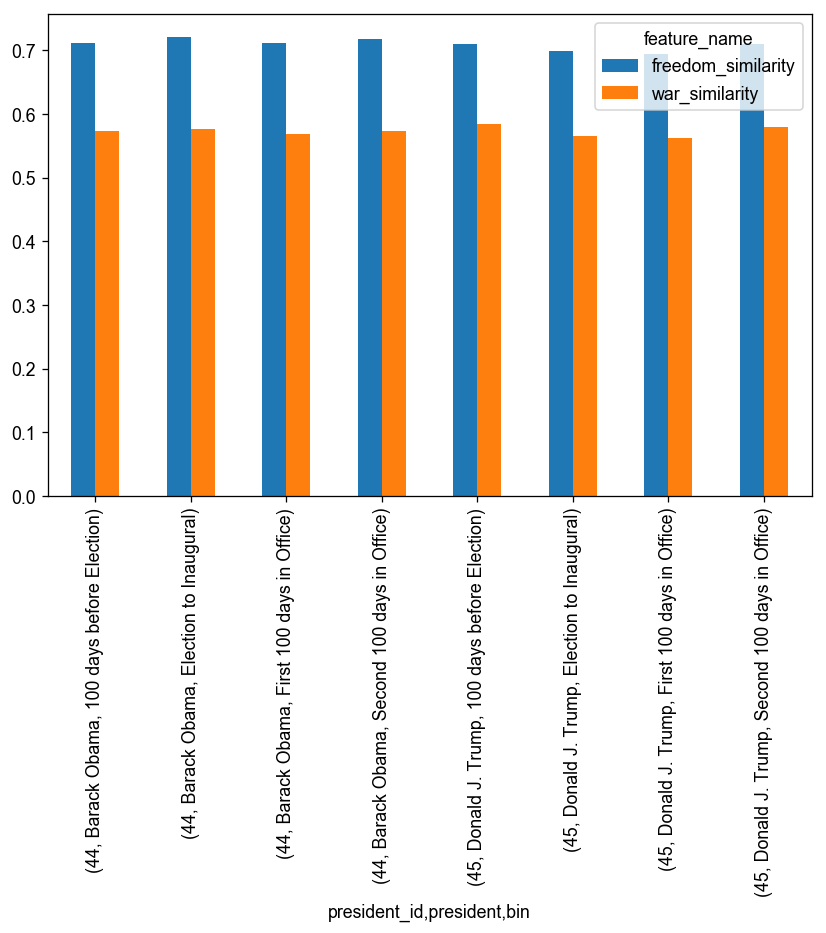

In [37]:
df_spacy_distance.plot(kind='bar')

## Keyword context similarity

In [38]:
def create_keyword_similarity_df(presidents, keyword_docs, target_docs, preceding_tokens, subsequent_tokens):
    columns = pd.Index(['president', 'keyword', 'target', 'similarity'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            doc = load_president_doc(president)
            # baseline
            for target_doc in target_docs:
                yield name, 'overall', target_doc[0].text, target_doc.similarity(doc)
            # keyword matches
            for keyword_doc in keyword_docs:
                keyword_re = re.compile(r'\b' + keyword_doc.text + r'\b', re.I)
                for pre_span, _, post_span in context_spans(doc, keyword_re, preceding_tokens, subsequent_tokens):
                    for target_doc in target_docs:
                        similarity = np.mean([target_doc.similarity(pre_span), 
                                              target_doc.similarity(post_span)])
                        yield name, keyword_doc.text, target_doc[0].text, similarity
    return pd.DataFrame(iter_rows(), columns=columns)

keyword_docs = [nlp('North Korea'), nlp('Russia'), nlp('Japan')]
# target_docs = [nlp('war'), nlp('freedom')] # non-seeded
target_docs = [war_doc, freedom_doc]
keyword_similarity_df = create_keyword_similarity_df([44, 45], keyword_docs, target_docs, 50, 50)

Text(0,0.5,'Similarity (0 = completely different)')

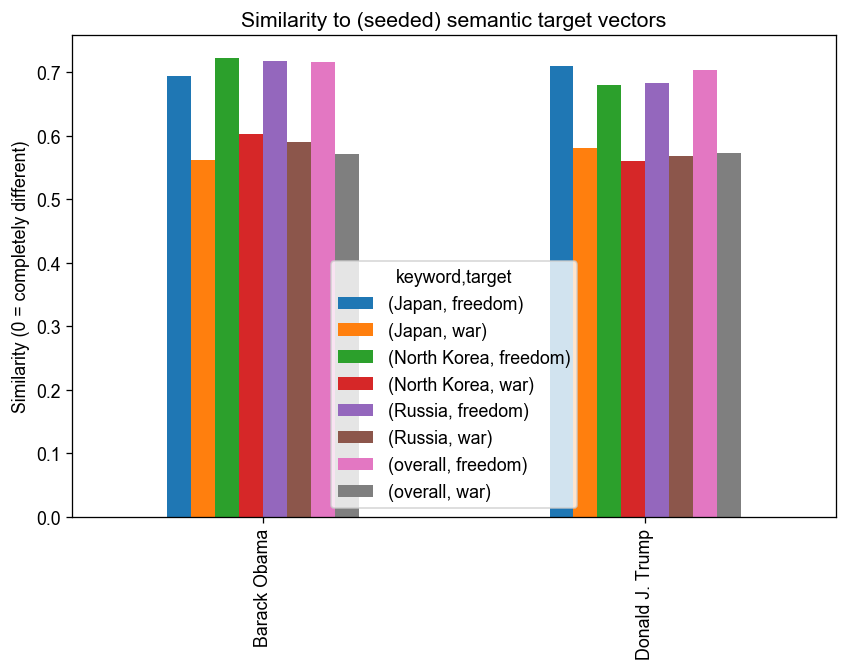

In [39]:
df = keyword_similarity_df.pivot_table(index=['president'], columns=['keyword', 'target'])
df.similarity.plot(kind='bar')
plt.title('Similarity to (seeded) semantic target vectors')
plt.xlabel('')
plt.ylabel('Similarity (0 = completely different)')

## spaCy inter-bin similarity 

In [40]:
def create_spacy_similarity_df(presidents):
    columns = pd.Index(['president_id', 'president', 'bins', 'similarity'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president)
            for bindoc1, bindoc2 in sliding_window(2, bindocs):
                similarity = bindoc1.similarity(bindoc2)
                description = sim_description(bindoc1, bindoc2)
                yield president, name, description, similarity
    return pd.DataFrame(iter_rows(), columns=columns)

df_spacy_similarity = create_spacy_similarity_df([41, 42, 43, 44, 45])

In [41]:
df = df_spacy_similarity.pivot_table(values='similarity', index=['president_id', 'president'], columns='bins')
df = df.reset_index('president_id', drop=True)
df

bins,100 days before Election ↔ Election to Inaugural,Election to Inaugural ↔ First 100 days in Office,First 100 days in Office ↔ Second 100 days in Office
president,,,
George Bush,0.998706,0.996625,0.999375
William J. Clinton,0.982335,0.996745,0.999592
George W. Bush,0.990895,0.996257,0.998190
Barack Obama,0.996761,0.998646,0.999781
Donald J. Trump,0.996756,0.998632,0.998778


Text(0.5,1,"Similarity in spaCy's 300-dimension distributional vector space")

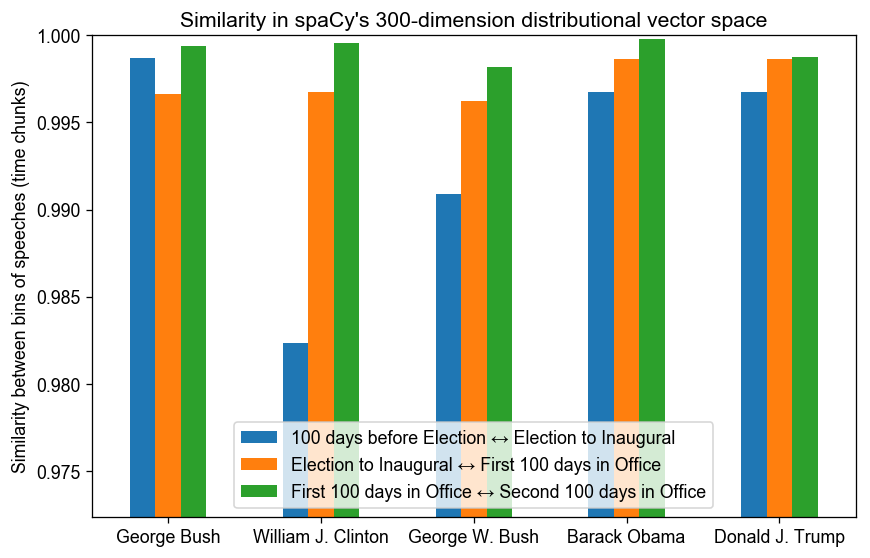

In [42]:
df.plot(kind='bar')
ymin = df.min().min()
plt.ylim(ymin - 0.01, 1.0)
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(loc='lower center')
plt.ylabel('Similarity between bins of speeches (time chunks)')
plt.title("Similarity in spaCy's 300-dimension distributional vector space")
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-spacy-similarity.pdf')

## Type overlap

In [43]:
def create_types_tokens_df(presidents):
    columns = pd.Index(['president', 'bin', 'types', 'tokens'])
    def iter_rows():
        for president in presidents:
            for bindoc in load_president_bindocs(president):
                bin_token_counts = token_counts(bindoc)
                yield (presidents_lookup[president], bindoc.user_data['description'], 
                       len(bin_token_counts), sum(bin_token_counts.values()))
    return pd.DataFrame(iter_rows(), columns=columns)

df_types_tokens = create_types_tokens_df([44, 45])

In [44]:
# df = df_types_tokens.pivot_table(values=['types', 'tokens'], index=['president'], columns='bin')
# df.plot(kind='bar')
# # plt.legend(loc='upper center')
# plt.legend(loc='best')
# plt.xticks(rotation=90)
# plt.xlabel('')
# plt.title('Tokens')

In [45]:
def create_type_overlap_df(presidents):
    columns = pd.Index(['president', 'bins', 'overlap'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president)
            for bindoc1, bindoc2 in sliding_window(2, bindocs):
                overlap = jaccard_index(token_counts(bindoc1).keys(), token_counts(bindoc2).keys())
                description = sim_description(bindoc1, bindoc2)
                yield name, description, overlap
    return pd.DataFrame(iter_rows(), columns=columns)

df_type_overlap = create_type_overlap_df([44, 45])
df_type_overlap

,president,bins,overlap
0,Barack Obama,100 days before Election ↔ Election to Inaugural,0.414913
1,Barack Obama,Election to Inaugural ↔ First 100 days in Office,0.425510
2,Barack Obama,First 100 days in Office ↔ Second 100 days in Office,0.473538
3,Donald J. Trump,100 days before Election ↔ Election to Inaugural,0.274862
4,Donald J. Trump,Election to Inaugural ↔ First 100 days in Office,0.196403
5,Donald J. Trump,First 100 days in Office ↔ Second 100 days in Office,0.427191


In [46]:
df = df_type_overlap.pivot_table(values='overlap', index=['president'], columns='bins')
df

bins,100 days before Election ↔ Election to Inaugural,Election to Inaugural ↔ First 100 days in Office,First 100 days in Office ↔ Second 100 days in Office
president,,,
Barack Obama,0.414913,0.425510,0.473538
Donald J. Trump,0.274862,0.196403,0.427191


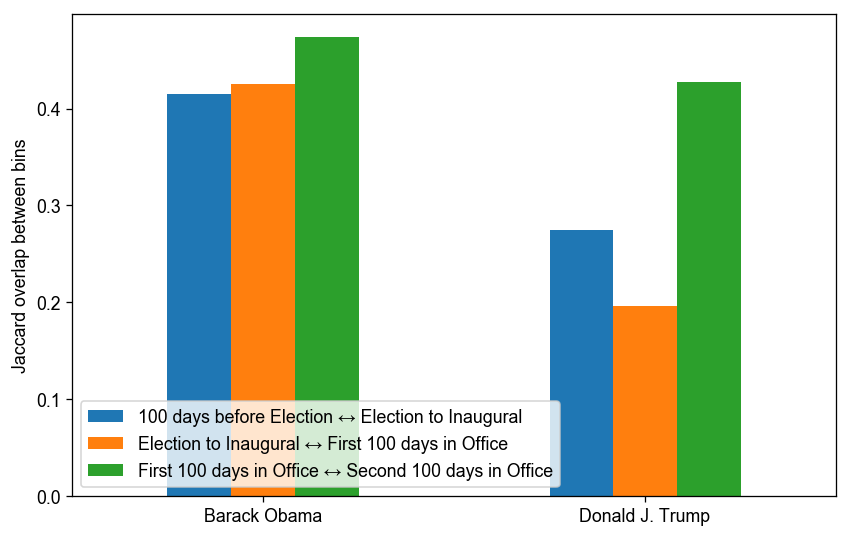

In [47]:
df.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Jaccard overlap between bins')
plt.legend(loc='lower left')

## LIWC Categorical-Dynamic Index

In [48]:
def create_cdi_df(presidents):
    columns = pd.Index(['president_id', 'president', 'bin', 'cdi'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president) 
            for bindoc in bindocs:
                bin_token_counts = token_counts(bindoc)
                yield president, name, bindoc.user_data['description'], cdi(bin_token_counts)
    return pd.DataFrame(iter_rows(), columns=columns)

df_cdi = create_cdi_df([41, 42, 43, 44, 45])

In [49]:
df = df_cdi.pivot_table(values='cdi', index=['president_id', 'president'], columns='bin')
df = df.reset_index('president_id', drop=True)
df

bin,100 days before Election,Election to Inaugural,First 100 days in Office,Second 100 days in Office
president,,,,
George Bush,-0.144703,-0.136814,-0.078779,-0.051045
William J. Clinton,-0.012034,-0.136457,-0.123864,-0.120425
George W. Bush,-0.138490,-0.131348,-0.075240,-0.037771
Barack Obama,-0.146753,-0.132802,-0.133243,-0.117656
Donald J. Trump,-0.140028,-0.184054,-0.159392,-0.119960


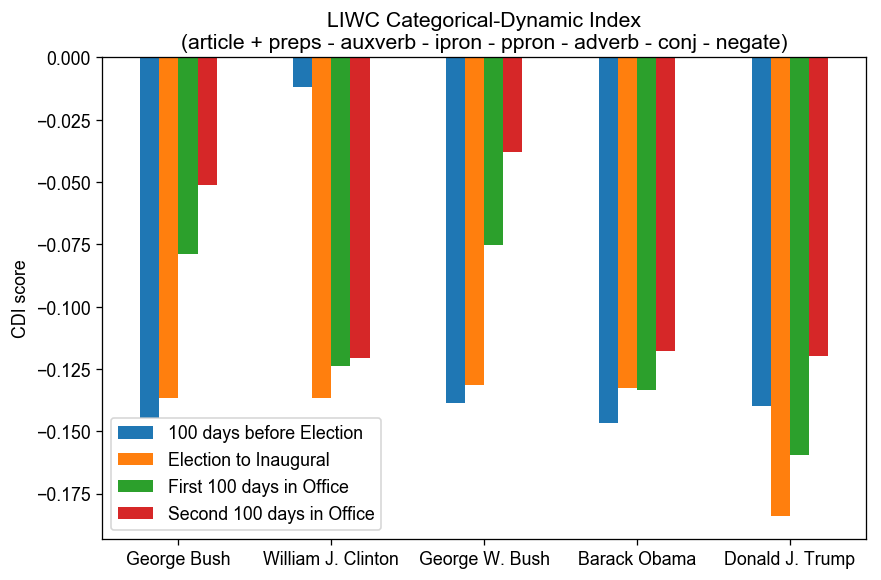

In [50]:
df.plot(kind='bar')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.xlabel('')
plt.ylabel('CDI score')
plt.title('LIWC Categorical-Dynamic Index\n(article + preps - auxverb - ipron - ppron - adverb - conj - negate)');
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-CDI.pdf')

## Token/type ratios

In [51]:
def token_to_type_ratio(counts):
    type_count = len(counts)
    token_count = sum(counts.values())
    if type_count > 0:
        return token_count / type_count
    # for our purposes, 0/0 = 1
    return 1.0

### Bin-wise token/type ratios

In [52]:
def create_token_type_ratio_df(presidents):
    columns = pd.Index(['president', 'bin', 'tokens/types'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president) 
            for bindoc in bindocs:
                bin_token_counts = token_counts(bindoc)
                yield name, bindoc.user_data['description'], token_to_type_ratio(bin_token_counts)
    return pd.DataFrame(iter_rows(), columns=columns).set_index('president')

df_token_type_ratio = create_token_type_ratio_df([44, 45])
df_token_type_ratio

,bin,tokens/types
president,,
Barack Obama,100 days before Election,30.700788
Barack Obama,Election to Inaugural,21.740733
Barack Obama,First 100 days in Office,35.514649
Barack Obama,Second 100 days in Office,30.530332
Donald J. Trump,100 days before Election,25.688113
Donald J. Trump,Election to Inaugural,7.511925
Donald J. Trump,First 100 days in Office,29.568516
Donald J. Trump,Second 100 days in Office,21.520833


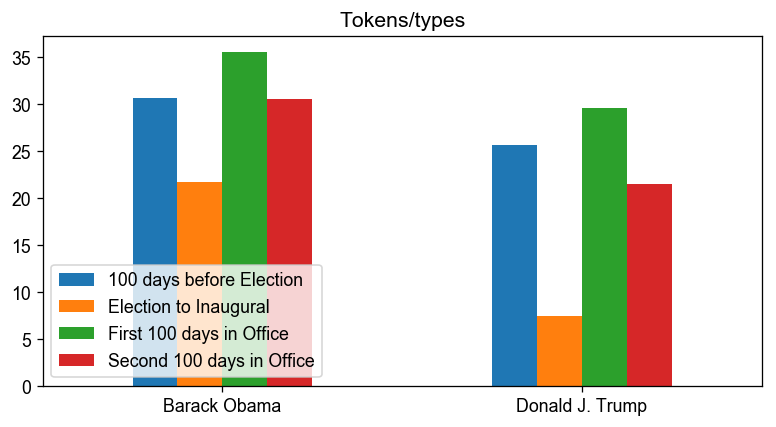

In [53]:
df = df_token_type_ratio.pivot_table(values='tokens/types', index=['president'], columns='bin')
df.plot(kind='bar', figsize=(8, 4))
plt.xticks(rotation=0)
plt.xlabel('')
plt.title('Tokens/types')
plt.legend(loc='lower left')

### Token/type trends

In [54]:
def create_token_type_trend_df(presidents, max_token_counts):
    columns = pd.Index(['president', 'tokens', 'types'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            doc = load_president_doc(president)
            for max_token_count in max_token_counts:
                if max_token_count < len(doc):
                    span = doc[0:max_token_count]
                    #span_token_counts = token_counts(span) # but there is no Span#count_by(...) :(
                    span_token_counts = Counter(token.lower_ for token in span)
                    span_types = len(span_token_counts)
                    yield name, max_token_count, span_types
    return pd.DataFrame(iter_rows(), columns=columns)

max_token_counts = list(concatv(range(1, 10, 1),
                                range(10, 100, 10),
                                range(100, 1000, 100),
                                range(1000, 10000, 1000),
                                range(10000, 100000, 10000),
                                range(100000, 1000000, 100000),
                                range(1000000, 10000000, 1000000)))
df_token_type_trend = create_token_type_trend_df([41, 42, 43, 44, 45], max_token_counts)

Text(0.5,1,'Tokens-types trends')

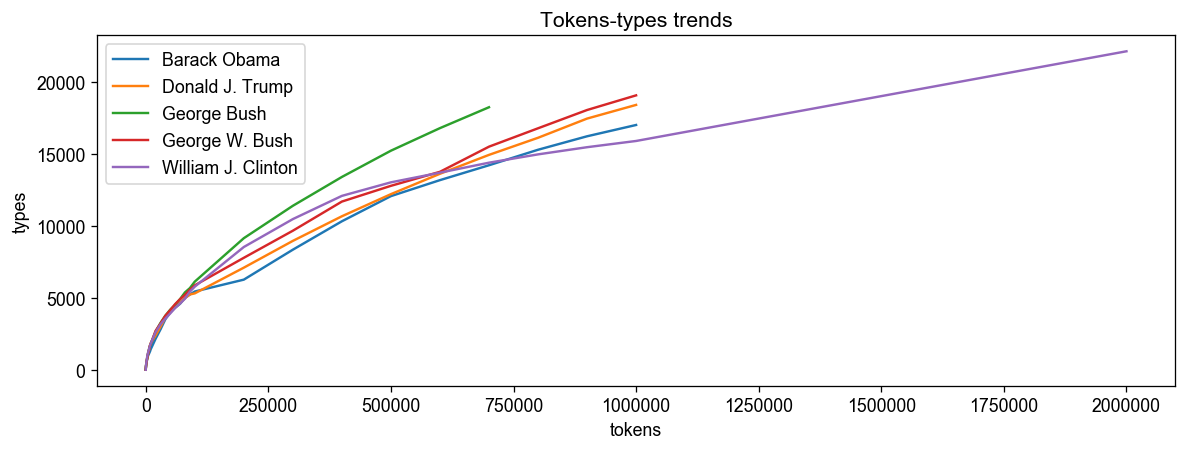

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, df_group in df_token_type_trend.groupby('president'):
    df_group.plot('tokens', 'types', ax=ax, label=label)
plt.xlabel('tokens')
plt.ylabel('types')
plt.title('Tokens-types trends')

## LIWC Inter-bin Similarity

In [56]:
def create_liwc_similarity_df(presidents, selected_liwc_category_names):
    columns = pd.Index(['president_id', 'president', 'bins', 'similarity'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president)
            for bindoc1, bindoc2 in sliding_window(2, bindocs):
                liwc1, liwc2 = [liwc_scores(token_counts(bindoc)) for bindoc in [bindoc1, bindoc2]]
                values1, values2 = [[liwc[k] for k in selected_liwc_category_names] for liwc in [liwc1, liwc2]]
                similarity = 1 - spatial.distance.cosine(values1, values2)
                description = sim_description(bindoc1, bindoc2)
                yield president, name, description, similarity
    return pd.DataFrame(iter_rows(), columns=columns)

all_liwc_category_names = liwc_category_names
emo_liwc_category_names = ['posemo', 'negemo']
cdi_liwc_category_names = ['article', 'preps', 'auxverb', 'ipron', 'ppron', 'adverb', 'conj', 'negate']

selected_liwc_category_names = all_liwc_category_names
df_liwc_similarity = create_liwc_similarity_df([41, 42, 43, 44, 45], selected_liwc_category_names)

In [57]:
df = df_liwc_similarity.pivot_table(values='similarity', index=['president_id', 'president'], columns='bins')
df = df.reset_index('president_id', drop=True)

Text(0.5,1,'Similarity in 64-category LIWC vector space\n(normalized by word count)')

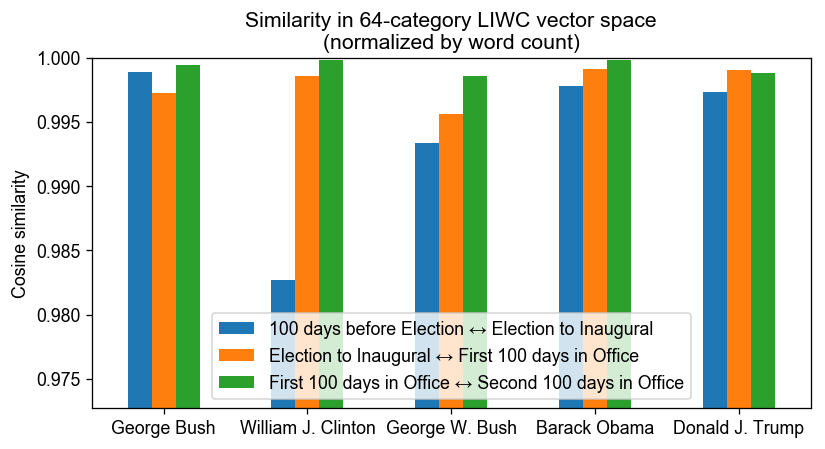

In [58]:
df.plot(kind='bar', figsize=(8, 4))
ymin = df.min().min()
plt.ylim(ymin - 0.01, 1.0)
plt.xlabel('')
plt.ylabel('Cosine similarity')
plt.xticks(rotation=0)
plt.legend(loc='lower center')
plt.title("Similarity in {}-category LIWC vector space\n(normalized by word count)".format(len(selected_liwc_category_names)))
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-liwc-similarity.pdf')

## Word Clouds !!!

In [144]:
# pip install -U wordcloud
import wordcloud
from wordcloud import WordCloud

In [484]:
short_stopwords = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'by', 'for', 'from', 'have', 'had', 'has', 
    'in', 'into', 'is', 'it', 'of', 'on', 'or', 'such', 'that', 'the', 'then', 'this', 'to',
    'was', 'were', 'which', 'will', 'with', 'would'}

In [537]:
from matplotlib.colors import LinearSegmentedColormap, Colormap

In [555]:
max_font_size = 150
# mpl_colormap = plt.cm.get_cmap('Reds_r')
mpl_colormap = LinearSegmentedColormap.from_list('DarkReds', [(0.3, 0.1, 0.1), (1, 0.1, 0.1)])

def wordcloud_color_func(word, font_size, position, orientation, font_path, random_state):
    rgba = mpl_colormap(1 - font_size / max_font_size)
    r, g, b, _ = 255 * np.array(rgba)
    return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

def create_doc_wordcloud(doc):
    doc_token_counts = token_counts(doc)
    doc_token_counts = dissoc(doc_token_counts, *short_stopwords)
    wordcloud = WordCloud(width=800, height=600, 
                          max_words=250,
                          max_font_size=max_font_size,
                          color_func=wordcloud_color_func,
                          mode='RGBA',
                          background_color=None)
    return wordcloud.generate_from_frequencies(doc_token_counts)

In [487]:
trump_doc = load_president_doc(45)

In [511]:
realDonaldTrump_twitter_docs = load_twitter_docs('realDonaldTrump')
last_2_years_realDonaldTrump_twitter_docs = [doc for doc in realDonaldTrump_twitter_docs 
                                             if doc.user_data['timestamp'] > '2015-11-02']
last_2_years_realDonaldTrump_twitter_doc = merge_docs(last_2_years_realDonaldTrump_twitter_docs,
                                                      'Last 2 years of @realDonaldTrump tweets')

INFO:presidents:Loading twitter docs from disk


In [583]:
import cairo

In [781]:
class CairoImageContext(object):
    def __init__(self, width, height, format=cairo.FORMAT_ARGB32):
        self.surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
        
    def __enter__(self):
        return cairo.Context(self.surface)
        
    def __exit__(self, exc_type, exc_value, traceback):
        if exc_type or exc_value or traceback:
            logger.error('%s Error: %s: %s (%s)', self.__name__, exc_type, exc_value, traceback)
        else:
            png_filepath = '/tmp/cairo.context.png'
            self.surface.write_to_png(png_filepath)
            self.surface.finish()
            display(Image(png_filepath))

In [902]:
def draw_text(ctx, font_size, text, x=0, y=0, draw_bbox=True):
    ctx.save()
    ctx.move_to(x, y)
    ctx.set_font_size(font_size)
    x_bearing, y_bearing, width, height, _, _ = ctx.text_extents(text)
    ctx.show_text(text)
    if draw_bbox:
        # normally text is drawn at the current origin, such that the text ends entirely above the x-axis line
        draw_rectangle(ctx, x_bearing, y_bearing, width, height)
    ctx.restore()

In [903]:
def draw_text_inside(ctx, font_size, text, x=0, y=0):
    ctx.save()
    ctx.set_font_size(font_size)
    x_bearing, y_bearing, width, height, x_advance, y_advance = ctx.text_extents(text)
    ctx.translate(x - 0, y - y_bearing)
    ctx.move_to(0, 0)
    ctx.show_text(text)
    ctx.restore()

In [911]:
def draw_text_inside_rotated(ctx, font_size, text, x=0, y=0):
    ctx.save()
    ctx.set_font_size(font_size)
    x_bearing, _, width, _, _, _ = ctx.text_extents(text)
    ctx.translate(x, y)
    ctx.rotate(-math.pi / 2)
    ctx.translate(-width-x_bearing, 0)
    draw_text_inside(ctx, font_size, text)
    ctx.restore()    

In [919]:
def parse_pil_color(string):
    m = re.match(r'rgb\((\d+), (\d+), (\d+)\)', string)
    return [int(m.group(group)) for group in [1, 2, 3]]

def draw_wordcloud(ctx, wordcloud):
    ctx.select_font_face("DroidSansMono", cairo.FONT_SLANT_NORMAL, cairo.FONT_WEIGHT_NORMAL)
    for (word, freq), fontSize, (y, x), orientation, color in wordcloud.layout_:
        r, g, b = np.array(parse_pil_color(color)) / 255
        ctx.set_source_rgb(r, g, b)

        if orientation == 2:
            draw_text_inside_rotated(ctx, fontSize, word, x, y)
        else:
            draw_text_inside(ctx, fontSize, word, x, y)
            
def display_wordcloud(wordcloud):
    with CairoImageContext(wordcloud.width, wordcloud.height) as ctx:
        draw_wordcloud(ctx, wordcloud)

def export_wordcloud_pdf(wordcloud, filename, dirpath=exports_dirpath):
    filepath = os.path.join(dirpath, filename)
    try:
        with open(filepath, 'xb') as file:
            surface = cairo.PDFSurface(file, wordcloud.width, wordcloud.height)
            ctx = cairo.Context(surface)
            draw_wordcloud(ctx, wordcloud)
            surface.finish()
        logger.info('Wrote wordcloud to "%s"', filepath)
    except FileExistsError as ex:
        logger.warning('Not writing wordcloud: %s', ex)

In [923]:
trump_wordcloud = create_doc_wordcloud(trump_doc)
last_2_years_realDonaldTrump_twitter_wordcloud = create_doc_wordcloud(last_2_years_realDonaldTrump_twitter_doc)

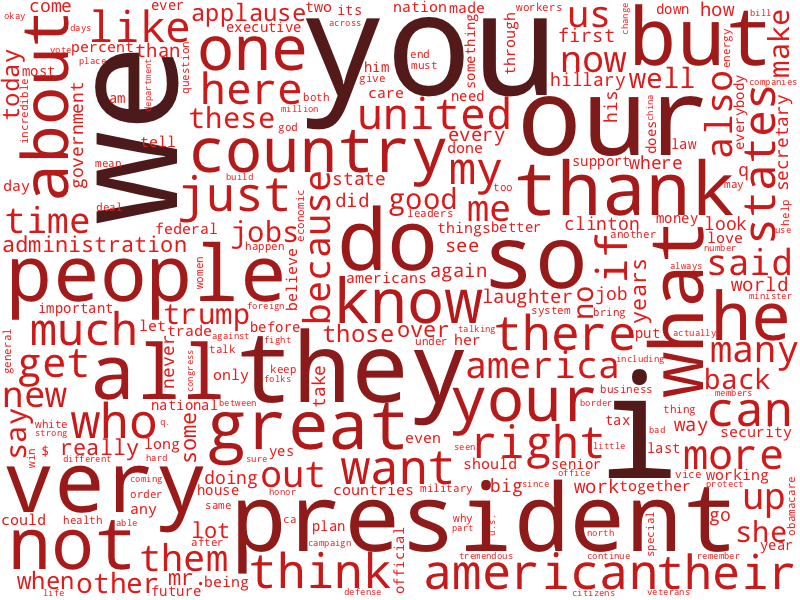

In [924]:
display_wordcloud(trump_wordcloud)

In [925]:
export_wordcloud_pdf(trump_wordcloud, '03_wordcloud-Trump_speeches-N=250.pdf')

INFO:presidents:Wrote wordcloud to "/Users/chbrown/github/presidents/notebooks/Inaugural-Shift/03_wordcloud-Trump_speeches-N=250.pdf"


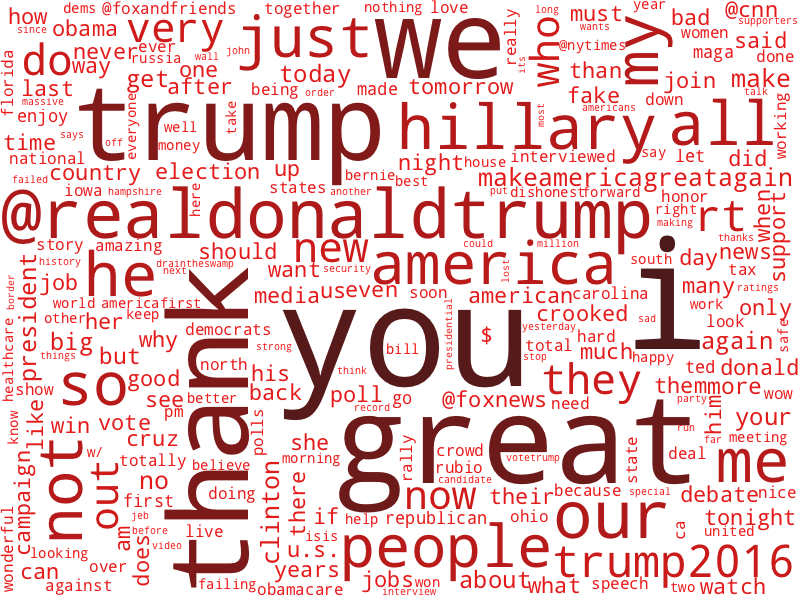

In [926]:
display_wordcloud(last_2_years_realDonaldTrump_twitter_wordcloud)

In [927]:
export_wordcloud_pdf(last_2_years_realDonaldTrump_twitter_wordcloud, '03_wordcloud-Trump_tweets-N=250.pdf')

## Fancy textacy analysis

In [62]:
from textacy.keyterms import most_discriminating_terms

In [63]:
def iter_president_terms(president):
    for paper in load_president_papers(president):
        # all we need is tokenization
        doc = nlp(paper['text'], tag=False, parse=False, entity=False)
        yield [token.text for token in doc]

In [64]:
%%time
terms1 = list(iter_president_terms(44))
terms2 = list(iter_president_terms(45))

CPU times: user 35.9 s, sys: 3.41 s, total: 39.3 s
Wall time: 39.8 s


In [65]:
%%time
top_n_terms = most_discriminating_terms(terms1 + terms2, [True]*len(terms1) + [False]*len(terms2),
                                        max_n_terms=1000, top_n_terms=100)

CPU times: user 1min 43s, sys: 530 ms, total: 1min 43s
Wall time: 1min 44s


In [66]:
pd.DataFrame(list(zip(*top_n_terms)), columns=['Obama', 'Trump'])

,Obama,Trump
0,Michelle,Trump
1,extraordinary,Hillary
2,kids,–
3,recession,incredible
4,progress,honor
5,still,border
6,21st,disaster
7,challenges,Great
8,century,really
9,afford,immigration


## Classifier-driven distinctive terms 

(using scikit-learn)

In [67]:
def featurize_spacy_docs(docs, attr_id=spacy.attrs.LOWER):
    '''
    Convert `docs` to arrays of counts, all with the same length.

    Returns a tuple of:
    * [0] 1-d np.array of feature names (strings), based on the given `attr_id`
    * [1] 2-d np.array of counts

    `docs` is a sequence of spaCy docs
    '''
    dict_vectorizer = feature_extraction.DictVectorizer(np.int64, sparse=False)
    X = dict_vectorizer.fit_transform(doc.count_by(attr_id) for doc in docs)
    feature_names = dict_vectorizer.get_feature_names()
    # map the feature keys through the string store to get back strings
    #feature_strings = np.vectorize(nlp.vocab.strings.__getitem__)(feature_names) # TODO: figure out why this doesn't work
    feature_strings = [nlp.vocab.strings[feature_name] for feature_name in feature_names]
    # or: list(map(nlp.vocab.strings.__getitem__, feature_names))
    return X, feature_strings

In [68]:
def tfidf_transform(X):
    tfidf_transformer = feature_extraction.text.TfidfTransformer()
    return tfidf_transformer.fit_transform(X)

In [69]:
def lr_distinguish(docs, labels, featurize_attr_id=spacy.attrs.LOWER, tfidf=False):
    X, feature_strings = featurize_spacy_docs(docs, featurize_attr_id)
    # X.shape == (<docs size>, <vocab_size, e.g., 29120>)
    if tfidf:
        X = tfidf_transform(X)
    lr = linear_model.LogisticRegression()
    lr.fit(X, labels)
    return np.concatenate((lr.intercept_, lr.coef_.ravel())), ['-INTERCEPT-'] + feature_strings

def create_lr_distinguish_df(docs, labels, featurize_attr_id=spacy.attrs.LOWER, tfidf=False):
    coefficients, feature_strings = lr_distinguish(docs, labels, featurize_attr_id, tfidf)
    return pd.DataFrame(list(zip(coefficients, feature_strings)),
                        columns=['coef', 'feature']).set_index('feature').sort_values('coef')

In [70]:
obama_doc = load_president_doc(44)
trump_doc = load_president_doc(45)

In [71]:
%%time
obama_docs = load_president_docs(44)
trump_docs = load_president_docs(45)

INFO:presidents:Loading docs from disk for president 44
INFO:presidents:Loading docs from disk for president 45


CPU times: user 19min 7s, sys: 19.6 s, total: 19min 27s
Wall time: 19min 34s


In [72]:
len(obama_docs), len(trump_docs)

(7856, 736)

In [73]:
create_lr_distinguish_df(obama_docs + trump_docs, [0]*len(obama_docs) + [1]*len(trump_docs),
                         featurize_attr_id=spacy.attrs.LOWER, tfidf=False)

,coef
feature,
-INTERCEPT-,-2.004096
barack,-1.296518
obama,-1.208862
michelle,-1.020449
area,-0.738545
resigned,-0.701839
district,-0.688745
w.,-0.616064
maryland,-0.569461


In [74]:
create_lr_distinguish_df(obama_docs + trump_docs, [0]*len(obama_docs) + [1]*len(trump_docs),
                         featurize_attr_id=spacy.attrs.POS, tfidf=False)

,coef
feature,
-INTERCEPT-,-2.289027
INTJ,-0.143532
X,-0.072632
PART,-0.045478
ADP,-0.037854
SYM,-0.030975
NOUN,-0.011124
ADV,-0.000376
PRON,0.004950


In [75]:
# df
coefficients, feature_strings = lr_distinguish([obama_doc, trump_doc], [0, 1])
df = pd.DataFrame(list(zip(coefficients, feature_strings)), 
                  columns=['Coef', 'Feature']).set_index('Feature').sort_values('Coef')
# df_tfidf
coefficients, feature_strings = lr_distinguish([obama_doc, trump_doc], [0, 1], tfidf=True)
df_tfidf = pd.DataFrame(list(zip(coefficients, feature_strings)),
                        columns=['Coef', 'Feature']).set_index('Feature').sort_values('Coef')
display(stats.pearsonr(df.Coef, df_tfidf.Coef))
df.join(df_tfidf, lsuffix='_tfidf')

(0.99976048688658659, 0.0)

,Coef_tfidf,Coef
Feature,,
that,-0.000335,-0.045799
the,-0.000159,-0.022366
to,-0.000158,-0.022029
in,-0.000118,-0.016202
of,-0.000117,-0.016240
a,-0.000072,-0.010032
is,-0.000070,-0.009702
this,-0.000070,-0.009630
--,-0.000065,-0.008863


## Basic syntax

In [76]:
google_1t_10k_path = os.path.join(root, 'stopwords', 'google-1t-10000.txt')
google_1t_10k_strings = list(read_strings(google_1t_10k_path))
top_1000_words = list(take(1000, unique(iter_substantive_words(google_1t_10k_strings))))
top_1000_words_set = set(top_1000_words)
top_2000_words = list(take(2000, unique(iter_substantive_words(google_1t_10k_strings))))
top_2000_words_set = set(top_2000_words)
top_5000_words = list(take(5000, unique(iter_substantive_words(google_1t_10k_strings))))
top_5000_words_set = set(top_5000_words)

In [77]:
def most_common_non_stopwords(tokens, n=None, stopwords=standard_stopwords):
    def is_non_stopword(word):
        return word not in stopwords
    for word, count in Counter(filter(is_non_stopword, iter_substantive_words(tokens))).most_common(n):
        yield word

In [78]:
def uses_only_1000_most_common_english_words(span):
    span_words = set(iter_substantive_words(span))
    return span_words.issubset(top_2000_words_set)

In [79]:
def uses_only_2000_most_common_english_words(span):
    span_words = set(iter_substantive_words(span))
    return span_words.issubset(top_2000_words_set)

In [80]:
def uses_only_5000_most_common_english_words(span):
    span_words = set(iter_substantive_words(span))
    return span_words.issubset(top_5000_words_set)

## Feature functions

A feature function has a descriptive and unique `__name__` attribute.
It takes a spaCy Doc and returns a scalar value.

In [81]:
# part-of-speech features
def n_words(doc):
    return count(token for token in doc if not (token.is_stop or token.is_punct or token.is_space))

def n_nouns(doc):
    return doc.count_by(spacy.attrs.POS)[nlp.vocab.strings['NOUN']]

def n_verbs(doc):
    return doc.count_by(spacy.attrs.POS)[nlp.vocab.strings['VERB']]

pos_feature_functions = [n_words, n_nouns, n_verbs]

In [82]:
# sentence features
def n_sents(doc):
    return count(doc.sents)
    
def n_short_sents(doc):
    return count(1 for sent in doc.sents if len(sent) < 10)

def n_sents_using_only_1000_mcew(doc):
    return count(1 for sent in doc.sents if uses_only_1000_most_common_english_words(sent))

def n_sents_using_only_5000_mcew(doc):
    return count(1 for sent in doc.sents if uses_only_5000_most_common_english_words(sent))

def _uses_only_own_N_most_common_words_func(own_doc, N):
    '''
    Helper for the n_sents_using_only_own_* feature functions below.
    '''
    own_N_most_common_words = set(dict(Counter(iter_substantive_words(own_doc)).most_common(N)).keys())
    def check(span):
        span_words = set(iter_substantive_words(span))
        return span_words.issubset(own_N_most_common_words)
    return check

def n_sents_using_only_own_2000_mcw(doc):
    uses_only_own_2000_most_common_words = _uses_only_own_N_most_common_words_func(doc, 2000)
    return count(1 for sent in doc.sents if uses_only_own_2000_most_common_words(sent))

def n_sents_using_only_own_2000_mcw_or_2000_mcew(doc):
    # it gets messy :(
    uses_only_own_2000_most_common_words = _uses_only_own_N_most_common_words_func(doc, 2000)
    return count(1 for sent in doc.sents if 
                 (uses_only_2000_most_common_english_words(sent) or
                  uses_only_own_2000_most_common_words(sent)))

sentence_feature_functions = [
    n_sents,
    n_short_sents,
    n_sents_using_only_1000_mcew,
    n_sents_using_only_5000_mcew,
    n_sents_using_only_own_2000_mcw,
    n_sents_using_only_own_2000_mcw_or_2000_mcew]

In [83]:
# (other) complexity features
def avg_sent_length(doc):
    return np.mean([len(sent) for sent in doc.sents])

def avg_word_length(doc):
    return np.mean([len(token) for token in doc])

def avg_token_prob(doc):
    return np.mean([token.prob for token in doc])

complexity_feature_functions = [avg_sent_length, avg_word_length, avg_token_prob]

In [84]:
%%time
df_syntactic_counts = create_featurized_df([41, 42, 43, 44, 45], 
                                           token_type_feature_functions + 
                                           pos_feature_functions + 
                                           sentence_feature_functions + 
                                           complexity_feature_functions)

CPU times: user 1min 33s, sys: 2.24 s, total: 1min 35s
Wall time: 1min 37s


In [85]:
# df.plot(kind='bar')
# df.transpose().plot(kind='bar')
# def plot_columns(df):
#     ncols = 3
#     fig, axes = plt.subplots(4, ncols, sharex=True)
#     for i, column in enumerate(df.columns):
#         row = i // ncols
#         col = i % ncols
#         ax = axes[row, col]
#         df[column].plot(kind='bar', ax=ax)
#         ax.set_title(column)
#         ax.set_xlabel('')

# df.reset_index('president_id', drop=True).
#     plot(kind='bar', subplots=True, layout=(1 + len(df.columns) // 2, 2), legend=None, figsize=(10, 16));

In [86]:
# df['ratio_short_sents'] = df.n_short_sents / df.n_sents
# (df.n_short_sents / df.n_sents).plot(kind='bar', figsize=(8, 4))
# plt.title('')
# plt.ylabel('#short sentences / #sentences')
# plt.xlabel('')
# plt.xticks(rotation=0)

In [87]:
df_syntactic_counts

,feature_name,avg_sent_length,avg_token_prob,avg_word_length,n_documents,n_nouns,n_sents,n_sents_using_only_1000_mcew,n_sents_using_only_5000_mcew,n_sents_using_only_own_2000_mcw,n_sents_using_only_own_2000_mcw_or_2000_mcew,n_short_sents,n_tokens,n_types,n_verbs,n_words
president_id,president,,,,,,,,,,,,,,,
41,George Bush,19.271874,-7.339621,4.080778,812.0,122297.0,41225.0,6509.0,12407.0,13726.0,14053.0,10933.0,794483.0,19446.0,123720.0,668968.0
42,William J. Clinton,14.158199,-7.073009,3.876235,915.0,368347.0,160583.0,59309.0,79126.0,95405.0,96700.0,77026.0,2273566.0,23036.0,409661.0,1888059.0
43,George W. Bush,18.363653,-7.236373,4.045262,769.0,159592.0,56301.0,8548.0,17500.0,22007.0,22436.0,15978.0,1033892.0,19800.0,174000.0,873924.0
44,Barack Obama,20.449584,-7.095109,4.033638,862.0,278723.0,82067.0,13718.0,24957.0,30602.0,31398.0,23610.0,1678236.0,22849.0,304453.0,1424142.0
45,Donald J. Trump,14.153145,-7.119351,3.894256,588.0,149104.0,72108.0,18791.0,29774.0,37769.0,38596.0,32394.0,1020555.0,18597.0,179951.0,830618.0


In [88]:
def create_percentage_bars_chart(df, series, ylabel):
    df_with_series = df.join(series.rename('value'))
    return Chart(df_with_series.reset_index(), width=500, height=300, mark='bar').encode(
        x=X('president:N', sort=SortField('president_id', op='values'), title='', axis=Axis(labelAngle=0)),
        y=Y('value', title=ylabel, axis=Axis(format='.0%')))

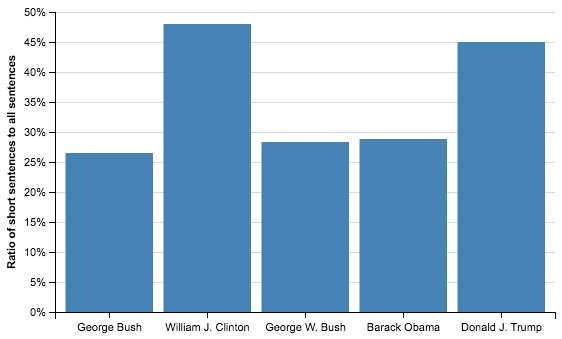

In [89]:
display(HTML('Ratio of short sentences (< 10 words)'))
short_sents_chart = create_percentage_bars_chart(df_syntactic_counts,
                                                 df_syntactic_counts.n_short_sents / df_syntactic_counts.n_sents,
                                                 'Ratio of short sentences to all sentences')
display(short_sents_chart)
# export_altair_chart(short_sents_chart, '05_short_sentences-ratio_lt_10_words')

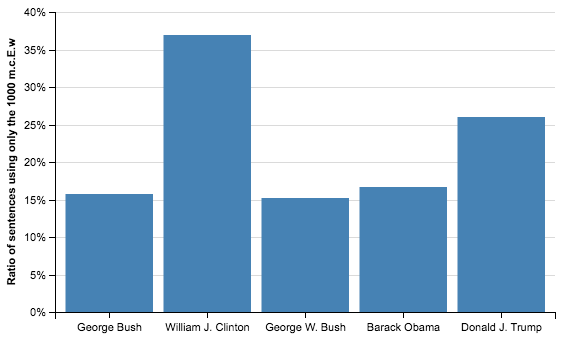

In [90]:
display(HTML('Ratio of sentences using only the 1000 most common English words, \
              based on Google 1T corpus of English unigrams'))
ratio_sents_1k_mcEw_chart = create_percentage_bars_chart(df_syntactic_counts,
                     df_syntactic_counts.n_sents_using_only_1000_mcew / df_syntactic_counts.n_sents,
                     'Ratio of sentences using only the 1000 m.c.E.w')
display(ratio_sents_1k_mcEw_chart)
# export_altair_chart(ratio_sents_1k_mcEw_chart, '04_sentences_using_only_1000_mcEw')

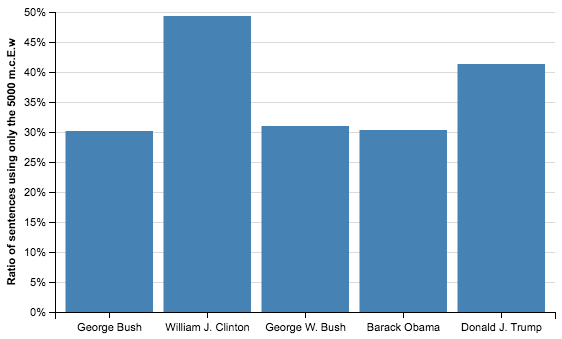

In [91]:
display(HTML('Ratio of sentences using only the 5000 most common English words, \
              based on Google 1T corpus of English unigrams'))
create_percentage_bars_chart(df_syntactic_counts,
                     df_syntactic_counts.n_sents_using_only_5000_mcew / df_syntactic_counts.n_sents,
                     'Ratio of sentences using only the 5000 m.c.E.w')

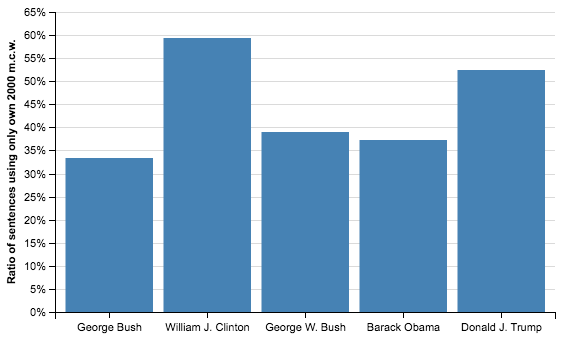

In [92]:
display(HTML('Ratio of sentences using only the 2000 most common words used by that president'))
create_percentage_bars_chart(df_syntactic_counts,
                     df_syntactic_counts.n_sents_using_only_own_2000_mcw / df_syntactic_counts.n_sents,
                     'Ratio of sentences using only own 2000 m.c.w.')

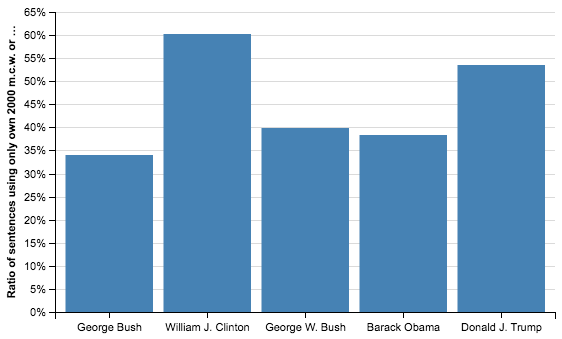

In [93]:
display(HTML('Ratio of sentences using only the 2000 most common words used by that president OR \
the most common 2000 words in the English language'))
create_percentage_bars_chart(df_syntactic_counts,
                             df_syntactic_counts.n_sents_using_only_own_2000_mcw_or_2000_mcew / df_syntactic_counts.n_sents,
                             'Ratio of sentences using only own 2000 m.c.w. or 2000 m.c.E.w.')

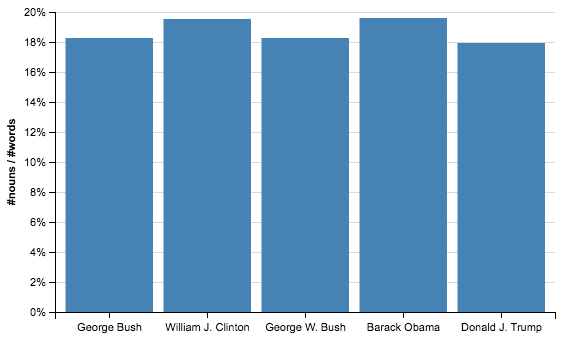

In [94]:
display(HTML('Ratio of nouns'))
create_percentage_bars_chart(df_syntactic_counts, df_syntactic_counts.n_nouns / df_syntactic_counts.n_words, '#nouns / #words')

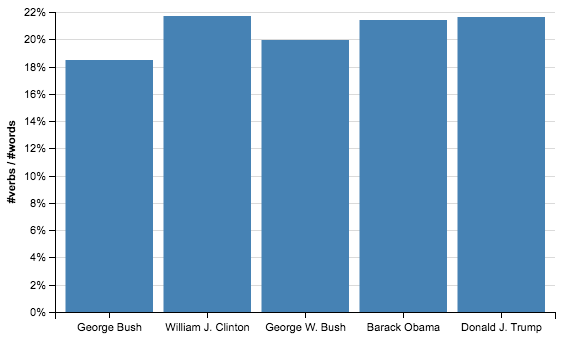

In [95]:
display(HTML('Ratio of verbs'))
create_percentage_bars_chart(df_syntactic_counts, df_syntactic_counts.n_verbs / df_syntactic_counts.n_words, '#verbs / #words')

## Us vs. them

In [96]:
us_tokens = 'us we our ourselves'.split()
us_re = re.compile(r'\b(us|we|our|ourselves)\b', re.I)
them_tokens = 'them they their themselves'.split()
them_re = re.compile(r'\b(them|they|their|themselves)\b', re.I)

In [97]:
def context_liwc_scores(haystack_doc, needle_re, window):
    '''
    Find all occurrences of needle_re in haystack_doc,
    then combine all the preceding `window` words with all the subsequent `window` words,
    and calculate their LIWC scores.
    '''
    context_tokens_generator = context_tokens(haystack_doc, needle_re, window, window)
    context_token_counts = Counter(token.lower_ for token in context_tokens_generator)
    return liwc_scores(context_token_counts)

In [98]:
def _term_frequency(needle_tokens, haystack_doc):
    doc_token_counts = token_counts(haystack_doc)
    return sum(doc_token_counts.get(k, 0) for k in needle_tokens) / len(haystack_doc)

def create_us_them_frequency_df(presidents):
    def us_frequency(doc):
        return _term_frequency(us_tokens, doc)
    def them_frequency(doc):
        return _term_frequency(them_tokens, doc)
    return create_featurized_df(presidents, [us_frequency, them_frequency])

def plot_us_them_frequency(df):
    df.plot(kind='bar', figsize=(8, 4))
    plt.title('Frequency of "us" ({}) vs. "them" ({})'.format('/'.join(us_tokens), '/'.join(them_tokens)))
    plt.xlabel('')
    plt.xticks(rotation=0)

# plot_us_them_frequency(create_us_them_frequency_df([41, 42, 43, 44, 45]))

In [99]:
def create_us_them_contexts_df(presidents, window, most_common_n, pivot=True):
    def us_top_words(doc):
        return list(most_common_non_stopwords(context_tokens(doc, us_re, window, window), most_common_n))
    def them_top_words(doc):
        return list(most_common_non_stopwords(context_tokens(doc, them_re, window, window), most_common_n))
    return create_featurized_df(presidents, [us_top_words, them_top_words], pivot=pivot)

In [100]:
def create_them_us_sentiment_ratio_df(presidents, window):
    def them_us_sentiment_ratio(doc):
        them_scores = context_liwc_scores(doc, them_re, window)
        them_sentiment = them_scores['negemo'] + them_scores['anger']
        us_scores = context_liwc_scores(doc, us_re, window)
        us_sentiment = us_scores['negemo'] + us_scores['anger']
        return them_sentiment / us_sentiment        
    return create_featurized_df(presidents, [them_us_sentiment_ratio])

def create_them_us_sentiment_ratio_chart(df):
    df['unity'] = 1.0
    return Chart(df.reset_index(), mark='bar', width=500, height=200).encode(    
        x=X('president:N', 
            axis=Axis(labelAngle=0), 
            title='', 
            sort=SortField('president_id', op='values'), 
           ),
        y2='unity',
        y=Y('them_us_sentiment_ratio:Q',
            title='Negative sentiment @ "them" / @ "us"',
            # TODO: get domain=[0.5, 1.5] in Scale to work even when Y2 is present
            scale=Scale(zero=False),
           ),
    )

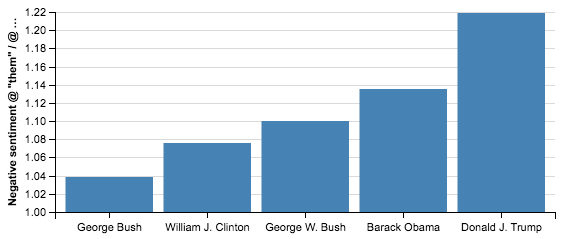

In [101]:
df_them_us_sentiment_ratio_10 = create_them_us_sentiment_ratio_df([41, 42, 43, 44, 45], 10)
chart = create_them_us_sentiment_ratio_chart(df_them_us_sentiment_ratio_10)
# export_altair_chart(chart, '01_us_vs_them-window=10-them-over-us')
display(chart)

In [102]:
def create_us_them_sentiment_df(presidents, window):
    def us_sentiment(doc):
        scores = context_liwc_scores(doc, us_re, window)
        return scores['posemo'] - scores['negemo']
    def them_sentiment(doc):
        scores = context_liwc_scores(doc, them_re, window)
        return scores['posemo'] - scores['negemo']
    return create_featurized_df(presidents, [us_sentiment, them_sentiment], pivot=False)

def create_us_them_sentiment_chart(df):
    return Chart(df, mark='bar', width=100, height=300).encode(
        color=Color('feature_name:N',
                    scale=Scale(range=['brown', 'indigo']),
                    legend=Legend(title='Context', values=['Them', 'Us']),
                   ),
        column=Column('president:N',
                      axis=Axis(grid=False, axisWidth=1.0, offset=-8.0, orient='bottom'),
                      title='',
                      sort=SortField('president_id', op='values'),
                     ),
        x=X('feature_name:N',
            axis=False,
           ),
        y=Y('feature_value:Q',
            title='Positive sentiment – negative sentiment', 
            axis=Axis(grid=False, format='.1%'),
           ),
    )

def create_and_plot_us_them_sentiment(presidents, window):
    title = 'Sentiment in {}-word contexts of "us" ({}) vs. "them" ({})'.format(
        window, '/'.join(us_tokens), '/'.join(them_tokens))
    display(HTML(title))
    df = create_us_them_sentiment_df(presidents, window)
    chart = create_us_them_sentiment_chart(df)
    display(chart)
    return chart

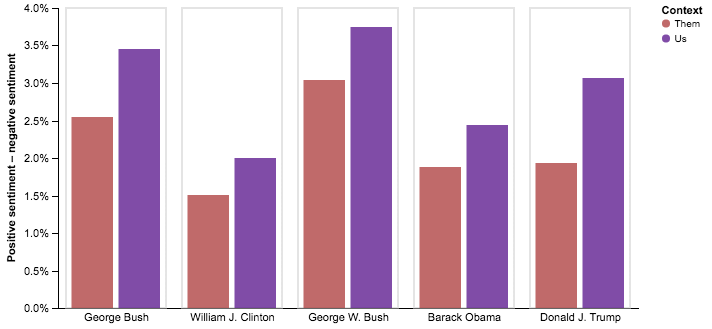

In [103]:
us_them_sentiment_10_chart = create_and_plot_us_them_sentiment([41, 42, 43, 44, 45], 10)
# export_altair_chart(us_them_sentiment_10_chart, '01_us_vs_them-window=10-posemo-negemo')

In [104]:
df_us_them_contexts_10 = create_us_them_contexts_df([41, 42, 43, 44, 45], 10, 20)
df_us_them_contexts_10

,feature_name,them_top_words,us_top_words
president_id,president,,
41,George Bush,"[people, president, know, think, work, right, need, q., american, tell, lives, america, children, states, like, country, time, good, americans, today]","[president, people, think, know, work, today, need, world, america, country, time, nation, united, american, together, national, states, good, future, great]"
42,William J. Clinton,"[people, think, president, know, mr, ms, myers, work, jobs, said, time, pay, health, money, like, country, today, tax, need, good]","[think, people, president, know, work, myers, mr, country, need, ms, time, continue, jobs, deficit, today, believe, economic, said, economy, working]"
43,George W. Bush,"[people, money, know, need, president, children, think, work, america, like, good, tax, country, government, right, time, thank, americans, families, today]","[people, need, work, country, america, know, nation, president, think, money, good, important, together, sure, today, government, believe, time, energy, tax]"
44,Barack Obama,"[people, need, care, jobs, health, families, know, time, think, work, americans, pay, american, homes, america, like, insurance, right, president, money]","[need, think, economy, people, know, work, health, time, president, care, country, together, america, crisis, energy, economic, system, american, sure, world]"
45,Donald J. Trump,"[people, know, country, great, like, think, right, president, said, jobs, doing, lot, love, american, need, time, countries, years, good, work]","[country, people, great, president, american, america, jobs, know, think, thank, right, together, nation, applause, today, work, doing, need, time, like]"


In [105]:
df = df_us_them_contexts_10.copy()
df.them_top_words = df.them_top_words.str.join(' ')
df.us_top_words = df.us_top_words.str.join(' ')
# df.to_csv('01_us_vs_them-window=10-most_common_contexts.csv', mode='x')
df

,feature_name,them_top_words,us_top_words
president_id,president,,
41,George Bush,people president know think work right need q. american tell lives america children states like country time good americans today,president people think know work today need world america country time nation united american together national states good future great
42,William J. Clinton,people think president know mr ms myers work jobs said time pay health money like country today tax need good,think people president know work myers mr country need ms time continue jobs deficit today believe economic said economy working
43,George W. Bush,people money know need president children think work america like good tax country government right time thank americans families today,people need work country america know nation president think money good important together sure today government believe time energy tax
44,Barack Obama,people need care jobs health families know time think work americans pay american homes america like insurance right president money,need think economy people know work health time president care country together america crisis energy economic system american sure world
45,Donald J. Trump,people know country great like think right president said jobs doing lot love american need time countries years good work,country people great president american america jobs know think thank right together nation applause today work doing need time like


In [106]:
# for window in [500, 100, 25, 10, 2, 1]:
#     create_and_plot_us_them_sentiment([41, 42, 43, 44, 45], window)

## Repetition

In [107]:
def iter_repeated_bigrams(strings, window):
    for window_strings in sliding_window(window, strings):
        # sliding_window yields tuples by default
        needle = window_strings[-2:]
        haystack = window_strings[:-2]
        if needle in set(sliding_window(2, haystack)):
            yield needle
            
def create_repeated_bigrams_df(president_ids, window, most_common_n):
    index_columns = ['president_id', 'president']
    data_columns = ['n_tokens', 'n_repeated_bigrams', 'most_common_repeated_bigrams']
    def iter_rows():
        for president_id in president_ids:
            name = presidents_lookup[president_id]
            doc = load_president_doc(president_id)
            repeated_bigram_strings = [' '.join(bigram) for bigram in iter_repeated_bigrams(iter_substantive_words(doc), window)]
            most_common_repeated_bigrams = [k for k, count in Counter(repeated_bigram_strings).most_common(most_common_n)]
            yield president_id, name, len(doc), len(repeated_bigram_strings), most_common_repeated_bigrams
    return pd.DataFrame(iter_rows(), columns=index_columns + data_columns).set_index(index_columns)

In [108]:
def create_repeated_bigrams_chart(df):
    value_column = 'Percentage of 2-word pairs that are repeated'
    series = df.n_repeated_bigrams / df.n_tokens
    df = df.join(series.rename(value_column))
    return Chart(df.reset_index(), mark='bar', width=500, height=275).encode(
        x=X('president:N',
            title='',
            axis=Axis(labelAngle=0),
            sort=SortField('president_id', op='values'),
           ),
        y=Y(value_column, 
            axis=Axis(format='.1%')
           ),
    )

def create_and_plot_repeated_bigrams(president_ids, window, most_common_n):
    df = create_repeated_bigrams_df(president_ids, window, most_common_n)
    display(HTML('Percentage of 2-word pairs that are repeated in previous {} words'.format(window)))
    chart = create_repeated_bigrams_chart(df)
    display(chart)
    return chart

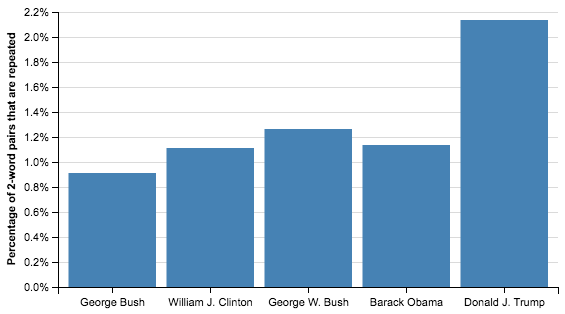

In [109]:
df_repeated_bigrams_10 = create_repeated_bigrams_df([41, 42, 43, 44, 45], 10, 20)
display(HTML('Percentage of 2-word pairs that are repeated in previous {} words'.format(10)))
chart_repeated_bigrams_10 = create_repeated_bigrams_chart(df_repeated_bigrams_10)
# export_altair_chart(chart_repeated_bigrams_10, '02_repeated_bigrams-window=10')
display(chart_repeated_bigrams_10)

In [110]:
df = df_repeated_bigrams_10.copy()
df.most_common_repeated_bigrams = df.most_common_repeated_bigrams.str.join('; ')
# df.to_csv('02_repeated_bigrams-window=10-most_common.csv', mode='x')
df

,,n_tokens,n_repeated_bigrams,most_common_repeated_bigrams
president_id,president,,,
41,George Bush,794483,7266,of the; in the; thank you; to the; and i; it 's; and the; god bless; for the; the president; going to; i 'm; we 're; want to; on the; that 's; i think; do n't; it is; i do
42,William J. Clinton,2273566,25218,of the; in the; it 's; the president; do n't; i think; to the; going to; that 's; we 're; and the; he 's; thank you; on the; ms myers; it was; we have; will be; to be; to do
43,George W. Bush,1033892,13077,of the; thank you; it 's; in the; that 's; i 'm; to the; and i; a lot; to be; going to; we 're; for the; the president; and the; he 's; 's a; want to; it is; from to
44,Barack Obama,1678236,19096,of the; thank you; it 's; that 's; going to; in the; we 're; we can; that we; i 'm; to be; to the; we will; we 've; this is; we have; i think; for the; the same; do n't
45,Donald J. Trump,1020555,21810,thank you; going to; it 's; we 're; of the; we will; 're going; they 're; we have; that 's; do n't; i 'm; we are; make america; will make; god bless; to be; a lot; in the; want to


In [111]:
# for window in [100, 50, 20, 10]:
#     create_and_plot_repeated_bigrams([41, 42, 43, 44, 45], window, 20)

## Authoritarian/liberty speech

In [113]:
authoritarian_lexicon = load_lexicon('authoritarian-manual.txt')
authoritarian_ff = TokenMatcher(authoritarian_lexicon, 'authoritarian terms')
democratic_lexicon = load_lexicon('democratic-manual.txt')
democratic_ff = TokenMatcher(democratic_lexicon, 'democratic terms')
liberty_lexicon = [
    'freedom', 'freedoms',
    'liberty', 'liberties', 
    'rights', 
    'public',
]
liberty_ff = TokenMatcher(liberty_lexicon, 'freedom/liberty/rights/public')
war_ff = TokenMatcher(war_lexicon, '100 war keywords')
freedom_ff = TokenMatcher(freedom_lexicon, '100 freedom keywords')

In [114]:
def create_feature_bar_chart(df, column_key, column_sort_key):
    index_field = SortField('index', op='values')
    return Chart(df.reset_index(), mark='bar', width=100, height=300).encode(
        color=Color('feature_name:N',
                    scale=Scale(range=['darkred', 'darkolivegreen']),
                    legend=Legend(title='Matching words'),
                    sort=index_field,
                   ),
        column=Column(column_key,
                      type='nominal',
                      axis=Axis(grid=False, axisWidth=1.0, offset=-8.0, orient='bottom'),
                      title='',
                      sort=SortField(column_sort_key, op='values'),
                     ),
        x=X('feature_name:N',
            axis=False,
            sort=index_field,
           ),
        y=Y('feature_value:Q',
            title='Percentage of total words in group', 
            axis=Axis(grid=False, format='%'),
           ),
    )

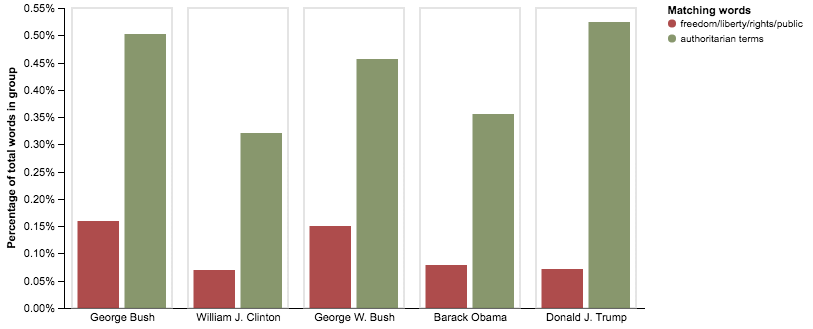

In [115]:
df_presidents_liberty_authoritarian = create_featurized_df([41, 42, 43, 44, 45], [liberty_ff, authoritarian_ff], pivot=False)
chart_presidents_liberty_authoritarian = create_feature_bar_chart(df_presidents_liberty_authoritarian, 'president', 'president_id')
display(chart_presidents_liberty_authoritarian)

In [116]:
export_altair_chart(chart_presidents_liberty_authoritarian, '06_lexicons-last5presidents-freedom_authoritarian')

In [117]:
%%time
# prepare doc collections
all_inaugurals_prior_to_trump_docs = [doc for doc in load_inaugural_docs() if doc.user_data['timestamp'] < '2017']
obama_presidential_speeches_docs = [doc for doc in load_president_docs(44) 
                                    if is_speech(dict(title=doc.user_data['title'], text=doc.text))]
trump_campaign_docs = [doc for doc in load_president_docs(45) if doc.user_data['timestamp'] < '2017-01-20']
trump_inaugural_docs = [doc for doc in load_inaugural_docs() if doc.user_data['author'] == 'Donald J. Trump']
trump_presidential_docs = [doc for doc in load_president_docs(45) if doc.user_data['timestamp'] > '2017-01-20']

In [118]:
%%time
# this is CPU expensive due to re-parsing the merged documents
selected_docs = [merge_docs(all_inaugurals_prior_to_trump_docs, 'All inaugurals prior to Trump'), 
                 merge_docs(obama_presidential_speeches_docs, 'Obama presidential speeches'),
                 merge_docs(trump_campaign_docs, 'Trump campaign'),
                 merge_docs(trump_inaugural_docs, 'Trump inaugural'),
                 merge_docs(trump_presidential_docs, 'Trump in-office'),
                ]

CPU times: user 26.5 s, sys: 9.09 s, total: 35.6 s
Wall time: 41.6 s


In [119]:
selected_docs[0].user_data['description'] = 'Inaugurals before Trump'
selected_docs[1].user_data['description'] = 'Obama speeches'

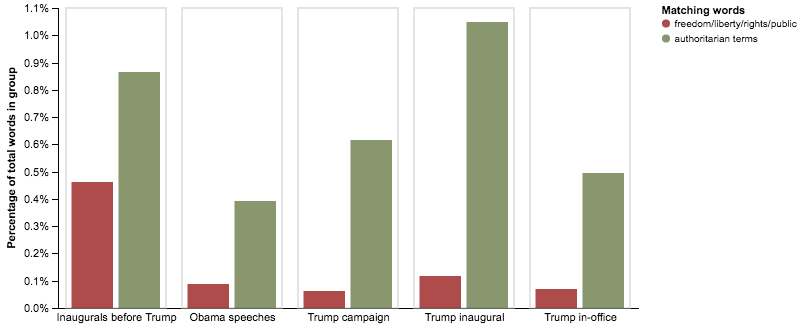

In [120]:
df_selected_liberty_authoritarian = create_featurized_docs_df(selected_docs, [liberty_ff, authoritarian_ff], pivot=False)
chart_selected_liberty_authoritarian = create_feature_bar_chart(df_selected_liberty_authoritarian, 'description', 'min_timestamp')
display(chart_selected_liberty_authoritarian)

In [121]:
export_altair_chart(chart_selected_liberty_authoritarian, '06_lexicons-selected_bins-freedom_authoritarian')

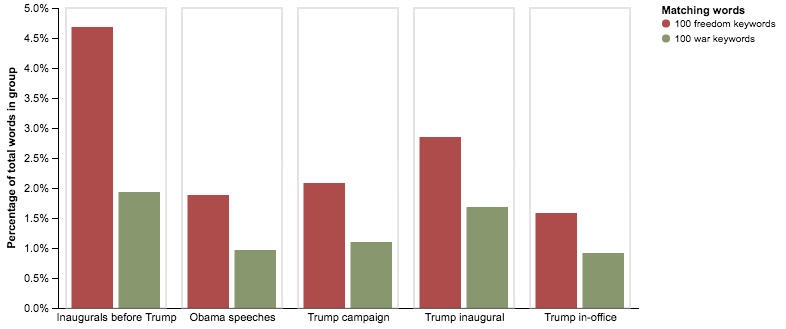

In [122]:
df_selected_freedom_war = create_featurized_docs_df(selected_docs, [freedom_ff, war_ff], pivot=False)
chart_selected_freedom_war = create_feature_bar_chart(df_selected_freedom_war, 'description', 'min_timestamp')
display(chart_selected_freedom_war)

In [123]:
export_altair_chart(chart_selected_freedom_war, '06_lexicons-selected_bins-war_freedom')